# Compute Equatorial Upwelling Current from ECCO version 4 release 4

In [1]:
from glob import glob
import warnings
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import ecco_v4_py as ecco
import pych.ecco as pe
from pych.plot import nice_inward_ticks

from matplotlib.ticker import MultipleLocator

/workspace/anaconda3/lib/python3.6/site-packages/docrep/__init__.py:413: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents(s)
/workspace/anaconda3/lib/python3.6/site-packages/docrep/__init__.py:342: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [2]:
import os 

In [3]:
fig_dir = '/workspace/results/eccov4r4/equatorial-under-current/figures/'

In [4]:
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
uvel_download_dir = '/workspace/ecco/release4/nctiles_monthly/UVELMASS/*/*.nc'
vvel_download_dir = '/workspace/ecco/release4/nctiles_monthly/VVELMASS/*/*.nc'

In [6]:
grid_dir = '/workspace/grids/llc90/'

In [7]:
ds = xr.open_mfdataset(glob(uvel_download_dir)+glob(vvel_download_dir))

/workspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/workspace/anaconda3/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this wil

In [8]:
g = pe.read_mds(grid_dir,iters=None)

/workspace/xmitgcm/xmitgcm/mds_store.py:854: UserWarning: Couldn't find available_diagnostics.log in /workspace/grids/llc90/ or /workspace/grids/llc90/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


## Create mask defining the Equatorial Upwelling Current (EUC)

Consider the region $140^\circ$E-$80^\circ$W, $1.5^\circ$S-$1.5^\circ$N, from the surface to 400m depth.

In [9]:
lon_left = np.arange(140,180,1)
lon_right = np.arange(-180,-79.5,1)

In [10]:
lon_list = np.concatenate((lon_left,lon_right))


In [11]:
for fld in ['drF','dyG','dxG','XC','XG','Zl','Zu','Zp1']:
    ds[fld] = g[fld]
    ds = ds.set_coords(fld)

## Load the time mean velocity above 400m into memory

In [12]:
ds['UVELMASS'] = ds.UVELMASS.sel(time=slice('1993','2017')).mean('time').load();
ds['VVELMASS'] = ds.VVELMASS.sel(time=slice('1993','2017')).mean('time').load();

### Load some often used coordinates to memory

In [13]:
ds['dyG'].load();
ds['dxG'].load();
ds['drF'].load();
ds['XC'].load();
ds['YC'].load();

In [14]:
grid = ecco.get_llc_grid(g)

## How many layers in the first 400m, and what are the thicknesses?

In [15]:
params = {'font.size':18,'lines.linewidth':2,'text.usetex':True,'axes.labelsize':18,'axes.titlesize':22}
plt.rcParams.update(params)

In [24]:
def autolabel(rects, labels=None, ypos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *ypos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for i,rect in enumerate(rects):
        width = rect.get_width()
        label = labels[i] if labels is not None else '{}'.format(width)
        ax.annotate(label,
                    xy=(width,rect.get_y() - rect.get_height() / 3),
                    xytext=(45,offset[ypos]*4-12),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[ypos], va='bottom')

In [17]:
max_depth = 420

In [18]:
ll = [f'{int(x+1)}: {z:.1f} m' for x,z in zip(ds.k.where(ds.Z>-max_depth,drop=True).values,ds.drF.where(ds.Z>-max_depth,drop=True).values)]

In [19]:
ds['d'] = -ds.Z

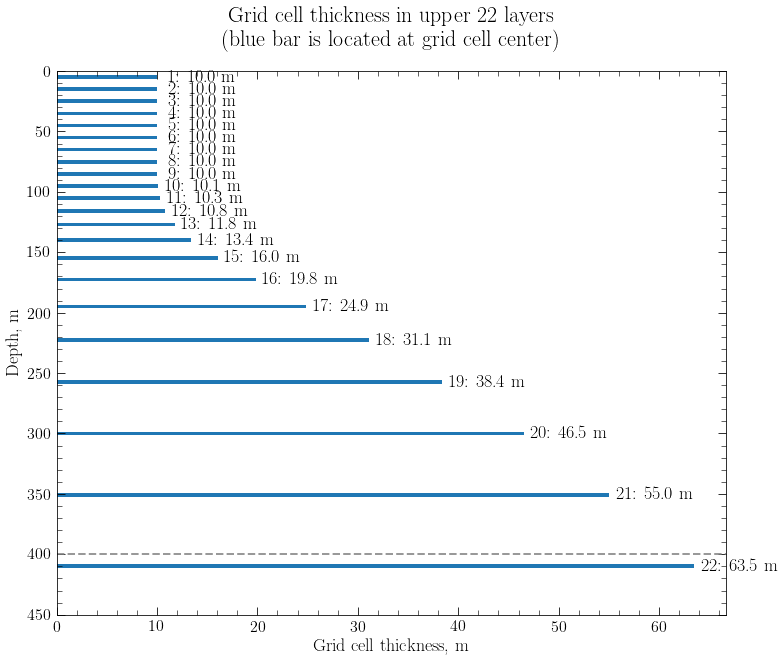

In [27]:
fig,ax = plt.subplots(1,1,figsize=(12,10))
bars = ax.barh(ds.d.where(ds.Z>-max_depth,drop=True),ds.drF.where(ds.Z>-max_depth,drop=True),height=3);
#for kk in ds.k.where(ds.Z>-400).values:
#    ax.text()
ax.set(ylim=[450,0])
autolabel(bars,labels=ll)
ax.set_ylabel('Depth, m')
ax.set_xlabel('Grid cell thickness, m')
ax.set_title('Grid cell thickness in upper 22 layers\n(blue bar is located at grid cell center)',pad=25);

ax.axhline(y=400,xmin=0,xmax=67,color='gray',linestyle='--',alpha=.8)

# --- Ticks
nice_inward_ticks(ax,xminor_skip=2,yminor_skip=10)
fig.savefig(f'{fig_dir}/grid_layer_thickness.png',
            bbox_inches='tight',dpi=300,pad_inches=1)

## Latitudinal distribution of grid cell width

Showing the telescoping LLC grid at the equator by grabbing 1.5S-1.5N at a single longitude.

In [27]:
lon = lon_list[-61]

In [28]:
maskW,maskS = ecco.calc_section_trsp._parse_section_trsp_inputs(ds,[lon,2],[lon,-2],None,None,'EUC')

/workspace/ECCOv4-py/ecco_v4_py/get_section_masks.py:51: UserWarning: 
Section name euc unavailable as pre-defined section
  warnings.warn('\nSection name %s unavailable as pre-defined section' % section_name)


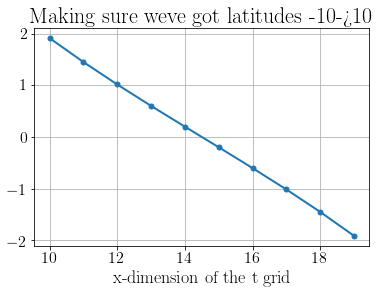

In [29]:
grid.interp(ds.YC,'Y',boundary='fill').where(maskS,drop=True).plot(marker='.',markersize=10)
plt.grid();
plt.title('Making sure we''ve got latitudes -10->10');

In [30]:
uvel_center_points = grid.interp(ds.YC,'Y',boundary='fill').where(maskS,drop=True).squeeze()
uvel_center_points

<xarray.DataArray (i: 10)>
array([ 1.91446483,  1.45120201,  1.01666545,  0.60210432,  0.19936521,
       -0.19936521, -0.60210432, -1.01666545, -1.45120201, -1.91446483])
Coordinates:
    tile     int64 8
    j_g      int64 78
  * i        (i) int64 10 11 12 13 14 15 16 17 18 19

In [31]:
uvel_bds = uvel_center_points - uvel_center_points.diff('i')/2 

In [32]:
dLat = (ds.dxG.where(maskS,drop=True)/1000).squeeze()

In [33]:
dLatMid = (dLat+dLat.shift(i=-1)).dropna('i')/2

In [34]:
(1.5-uvel_bds[1])/(uvel_bds[0]-uvel_bds[1])


<xarray.DataArray ()>
array(0.59270763)
Coordinates:
    i        int64 12
    tile     int64 8
    j_g      int64 78

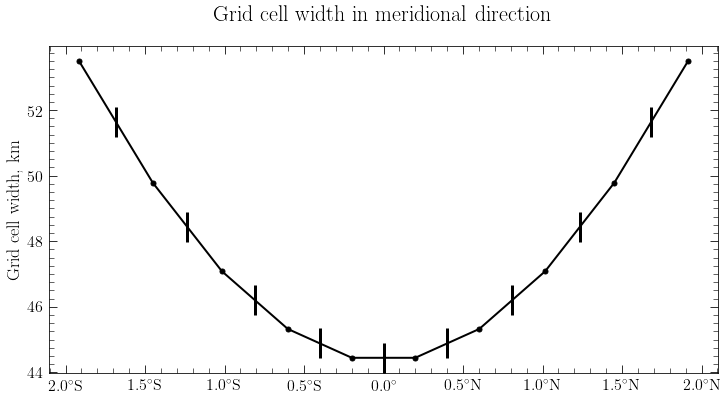

In [35]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(uvel_center_points,dLat,marker='.',markersize=10,color='k')
ax.plot(uvel_bds,dLatMid,marker='|',markersize=30,markeredgewidth=3,linestyle='',color='k')
#for x,y in zip(uvel_bds.values,dLatMid.values):
#    ax.text(x,y,'|')
ax.set_title(f'Grid cell width in meridional direction',pad=25)
ax.set_ylabel('Grid cell width, km')
#ax.set_xlabel('Latitude [$^\circ$]')
ax.set_xticklabels([r'%.1f$^\circ$%s' % (x,y) for x,y in \
                    zip([2,2,1.5,1,.5,0,.5,1,1.5,2],['S']*5+['']+['N']*4)])
nice_inward_ticks(ax,xminor_skip=.1,yminor_skip=0.25)
fig.savefig(f'{fig_dir}/grid_cell_width_equator.png',
            bbox_inches='tight',dpi=300,pad_inches=1)

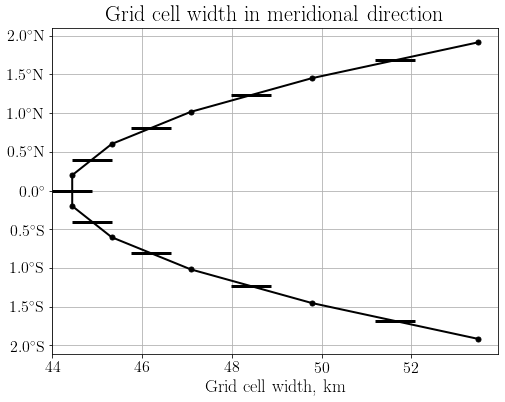

In [36]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(dLat,uvel_center_points,marker='.',markersize=10,color='k')
ax.plot(dLatMid,uvel_bds,marker='_',markersize=40,markeredgewidth=3,linestyle='',color='k')
#for x,y in zip(uvel_bds.values,dLatMid.values):
#    ax.text(x,y,'|')
ax.set_title(f'Grid cell width in meridional direction')
ax.set_xlabel('Grid cell width, km')
#ax.set_xlabel('Latitude [$^\circ$]')
ax.set_yticklabels([r'%.1f$^\circ$%s' % (x,y) for x,y in \
                    zip([2,2,1.5,1,.5,0,.5,1,1.5,2],['S']*5+['']+['N']*4)])
ax.grid();
fig.savefig(f'{fig_dir}/grid_cell_width_equator_portrait.png',
            bbox_inches='tight',dpi=300,pad_inches=1)

In [37]:
import cmocean

[Text(0, 0.5, 'Latitude'),
 Text(0.5, 0, 'Longitude'),
 Text(0.5, 1.0, 'Ocean Depth near 90W')]

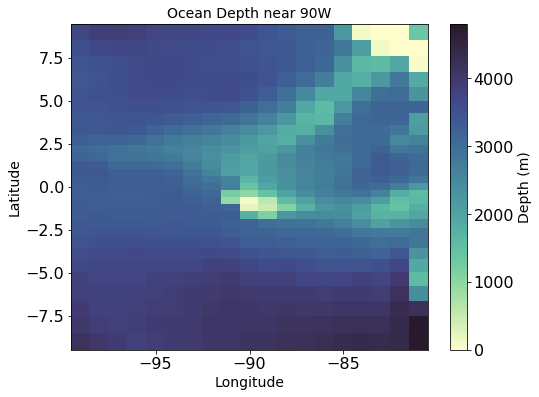

In [161]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
bds = (ds.YC>-10)&(ds.YC<10)&(ds.XC<-80)&(ds.XC>-100)
xc = ds.XC.where(bds,drop=True).squeeze()
yc = ds.YC.where(bds,drop=True).squeeze()
bathy = ds.Depth.where(bds,drop=True).squeeze()
cm = ax.pcolormesh(xc,yc,bathy,cmap='cmo.deep')
plt.colorbar(cm,label='Depth (m)')
ax.set(title='Ocean Depth near 90W',xlabel='Longitude',ylabel='Latitude')
#fig.savefig(f'{fig_dir}/ecco_galapagos_ocean_depth.png',dpi=300,bbox_inches='tight',pad_inches=1)

In [154]:
plt.rcParams.update({'text.usetex':False})

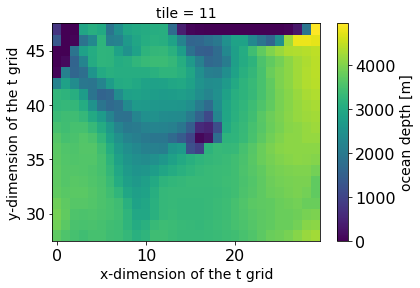

In [164]:
bathy.plot()

In [170]:
plt.rcParams.update({'text.usetex':True})

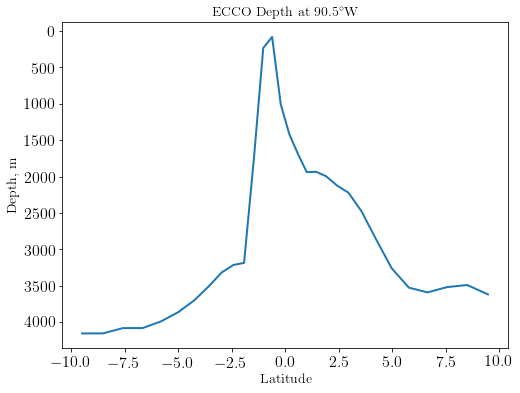

In [171]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
bathy.sel(j=37).plot(x='YC',yincrease=False)
ax.set(title='ECCO Depth at 90.5$^\circ$W',ylabel='Depth, m',xlabel='Latitude')
fig.savefig(f'{fig_dir}/ecco_depth_at_90W.png',dpi=300,bbox_inches='tight',pad_inches=1)

## How many grid cells in band 1.5S to 1.5N?

In [31]:
yf = grid.interp(ds.YC,'Y',boundary='fill').where(maskS,drop=True)
maskS.where(np.abs(yf)<=1.5,drop=True).sum().values

array(8.)

In [32]:
maskW15,maskS15 = ecco.calc_section_trsp._parse_section_trsp_inputs(ds,[lon,1.5],[lon,-1.5],None,None,'EUC')
print(maskS15.sum())

<xarray.DataArray ()>
array(8)


/workspace/ECCOv4-py/ecco_v4_py/get_section_masks.py:51: UserWarning: 
Section name euc unavailable as pre-defined section
  warnings.warn('\nSection name %s unavailable as pre-defined section' % section_name)


## Get EUC and depths at which Ubar=0

Get these depths by integrating velocity with depth and finding min/max

In [28]:
def calc_euc(ds,pt1,pt2,grid):
    
    # --- initialize output container
    trsp_ds = ecco.calc_section_trsp._initialize_section_trsp_data_array(ds)
    
    # --- Compute transport
    # get transport masks 
    maskW,maskS = ecco.calc_section_trsp._parse_section_trsp_inputs(ds,pt1,pt2,None,None,'EUC')
    
    # get latitude interpolated to velocity grid point
    yW = grid.interp(ds.YC,'X',boundary='fill')
    yS = grid.interp(ds.YC,'Y',boundary='fill')
    
    # interpolate the point at ~1.5N/S to get exactly the transport from -1.5to1.5
    # I figured this out by hand above because it's a pain...
    dy = 0.5927
    maskW = xr.where(np.abs(np.abs(yW)-1.5)<.2,dy*maskW,1*maskW)
    maskS = xr.where(np.abs(np.abs(yS)-1.5)<.2,dy*maskS,1*maskS)
    
    # Get surface area for transport
    area_x = ds['drF']*ds['dyG']*maskW
    area_y = ds['drF']*ds['dxG']*maskS
    
    # Get volumetric transport at grid cell
    xvol = ds['UVELMASS']*area_x
    yvol = ds['VVELMASS']*area_y
    
    # Integrate, only consider U>0
    # Note: I know this condition is OK because after multiplying by the masks above,
    # both xvol and yvol should be >0 for U>0 on the tiles in consideration here
    # also ... interpolate to get *exactly* the transport to 400m depth
    z0 = -400
    k0 = 21
    dz = -(z0 - ds.Zp1.isel(k_p1=k0))/ds.drF.isel(k=k0)
    
    trsp_x = xvol.where(ds.Z>z0).where(xvol>0).sum(dim=['i_g','j','tile','k'])
    trsp_x_frac = dz*xvol.where(ds.Z==ds.Z.isel(k=k0)).where(xvol>0).sum(dim=['i_g','j','tile','k'])
    
    trsp_y = yvol.where(ds.Z>z0).where(yvol>0).sum(dim=['i','j_g','tile','k'])
    trsp_y_frac = dz*yvol.where(ds.Z==ds.Z.isel(k=k0)).where(yvol>0).sum(dim=['i','j_g','tile','k'])
    
    trsp_ds['trsp'] = (trsp_x + trsp_x_frac + trsp_y + trsp_y_frac)* (10**-6)
    trsp_ds['trsp'].attrs['units'] = 'Sv'
    trsp_ds['maskW'] = maskW
    trsp_ds['maskS'] = maskS
    
    # --- Get depth where velocity is ~0
    
    # get velocity -vs- depth at this longitude
    u_eq = ds.UVELMASS.where(( np.abs(yW)<0.5) & (maskW>0),drop=True).mean('j').squeeze()
    v_eq = ds.VVELMASS.where(( np.abs(yS)<0.5) & (maskS>0),drop=True).mean('i').squeeze()
    
    # --- Get depth of maximum zonal velocity
    zu_core = ds.Z.where(u_eq==u_eq.max('k'))
    zv_core = ds.Z.where(v_eq==v_eq.max('k'))
    
    if not zv_core.any():
        if not zu_core.any():
            z_core=np.nan
        else:
            z_core = zu_core
    else:
        z_core = zv_core
    
    trsp_ds['Z_core'] = z_core.dropna('k')[0]
    
    trsp_ds['u_eq'] = u_eq if 'tile' not in u_eq.dims else v_eq
    
    # get locations where sign of velocity changes
    sgn_u = u_eq*u_eq.shift(k=1,fill_value=np.nan)
    sgn_v = v_eq*v_eq.shift(k=1,fill_value=np.nan)
    
    # and interpolate depth from this
    # get where lower velocity is greater than zero for top of the core
    u_frac = -u_eq/(u_eq.shift(k=1,fill_value=np.nan)-u_eq)
    v_frac = -v_eq/(v_eq.shift(k=1,fill_value=np.nan)-v_eq)
    z_u_upper = (ds.Z+(u_frac*(ds.Z.shift(k=1,fill_value=np.nan)-ds.Z))).where((sgn_u<=0) & (u_eq>=0)).dropna('k')
    z_v_upper = (ds.Z+(v_frac*(ds.Z.shift(k=1,fill_value=np.nan)-ds.Z))).where((sgn_v<=0) & (v_eq>=0)).dropna('k')
           
    # get where lower velocity is less than zero for bottom of the core
    u_frac = u_eq.shift(k=1)/(u_eq.shift(k=1,fill_value=np.nan)-u_eq)
    v_frac = v_eq.shift(k=1)/(v_eq.shift(k=1,fill_value=np.nan)-v_eq)
    z_u_lower = (ds.Z.shift(k=1,fill_value=np.nan)-(u_frac*(ds.Z.shift(k=1,fill_value=np.nan)-ds.Z))).where((sgn_u<=0) & (u_eq<=0)).dropna('k')
    z_v_lower = (ds.Z.shift(k=1,fill_value=np.nan)-(v_frac*(ds.Z.shift(k=1,fill_value=np.nan)-ds.Z))).where((sgn_v<=0) & (v_eq<=0)).dropna('k')
    
    Zl_upper = z_u_upper if not z_v_upper.any() else z_v_upper #z_u[0] if not z_v[0] else z_v[0]
    Zl_lower = z_u_lower if not z_v_lower.any() else z_v_lower #z_u[1] if not z_v[1] else z_v[1]
    
    # get lower and upper as Z values that bound Z_core
    trsp_ds['Zl_lower'] = Zl_lower.where(Zl_lower<float(trsp_ds['Z_core']),drop=True)[0]
    trsp_ds['Zl_upper'] = Zl_upper.where(Zl_upper>float(trsp_ds['Z_core']),drop=True)[-1]
    
    ## -- This is not a good idea because it gets min/max rather than first location where sign changes...
    # accumulate in Z to get min/max where U~0
    #u_cum = grid.cumsum(u_eq,'Z',boundary='fill')
    #v_cum = grid.cumsum(v_eq,'Z',boundary='fill')
    #
    #zlu_min = ds.Zl.where(u_cum==u_cum.min('k_l'))
    #zlv_min = ds.Zl.where(v_cum==v_cum.min('k_l'))
    #
    #zlu_max = ds.Zl.where(u_cum==u_cum.max('k_l'))
    #zlv_max = ds.Zl.where(v_cum==v_cum.max('k_l'))
    #
    #if not zlv_min.any():
    #    if not zlu_min.any():
    #        zl_min=np.nan
    #    else:
    #        zl_min = zlu_min
    #else:
    #    zl_min = zlv_min
    #    
    #if not zlv_max.any():
    #    if not zlu_max.any():
    #        zl_max=np.nan
    #    else:
    #        zl_max = zlu_max
    #else:
    #    zl_max = zlv_max
    #
    #trsp_ds['Zl_min'] = zl_min.dropna('k_l')[0]
    #trsp_ds['Zl_max'] = zl_max.dropna('k_l')[0]
    
    
    return trsp_ds

### Make a container dataset for EUC transport as a function of time and longitude

with field 'trsp' as zeros for now.

In [55]:
euc=xr.Dataset()
euc['lon'] = np.array(lon_list)
euc['Z'] = ds.Z.copy()

In [56]:
for fld in ['trsp','Zl_upper','Zl_lower','Z_core']:
    euc[fld] = xr.zeros_like(euc.lon,dtype=np.dtype('float64'))
    euc[fld].attrs={}
    
for fld in ['u_eq']:
    euc[fld] = xr.zeros_like(euc.Z*euc.lon,dtype=np.dtype('float64'))
    euc[fld].attrs={}

In [58]:
%%time
for i,lon in enumerate(lon_list):
    pt1 = [lon,1.5]
    pt2 = [lon,-1.5]
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        trsp_ds = calc_euc(ds,pt1=pt1,pt2=pt2,grid=grid)
        for fld in ['trsp','Zl_upper','Zl_lower','Z_core','u_eq']:
            euc[fld].loc[{'lon':lon}] = trsp_ds[fld].values
            euc[fld].attrs = trsp_ds[fld].attrs
    print(f' --- Done: {i}/{len(lon_list)} --- ')

 --- Done: 0/141 --- 
 --- Done: 1/141 --- 
 --- Done: 2/141 --- 
 --- Done: 3/141 --- 
 --- Done: 4/141 --- 
 --- Done: 5/141 --- 
 --- Done: 6/141 --- 
 --- Done: 7/141 --- 
 --- Done: 8/141 --- 
 --- Done: 9/141 --- 
 --- Done: 10/141 --- 
 --- Done: 11/141 --- 
 --- Done: 12/141 --- 
 --- Done: 13/141 --- 
 --- Done: 14/141 --- 
 --- Done: 15/141 --- 
 --- Done: 16/141 --- 
 --- Done: 17/141 --- 
 --- Done: 18/141 --- 
 --- Done: 19/141 --- 
 --- Done: 20/141 --- 
 --- Done: 21/141 --- 
 --- Done: 22/141 --- 
 --- Done: 23/141 --- 
 --- Done: 24/141 --- 
 --- Done: 25/141 --- 
 --- Done: 26/141 --- 
 --- Done: 27/141 --- 
 --- Done: 28/141 --- 
 --- Done: 29/141 --- 
 --- Done: 30/141 --- 
 --- Done: 31/141 --- 
 --- Done: 32/141 --- 
 --- Done: 33/141 --- 
 --- Done: 34/141 --- 
 --- Done: 35/141 --- 
 --- Done: 36/141 --- 
 --- Done: 37/141 --- 
 --- Done: 38/141 --- 
 --- Done: 39/141 --- 
 --- Done: 40/141 --- 
 --- Done: 41/141 --- 
 --- Done: 42/141 --- 
 --- Done: 43/141 ---

IndexError: index -1 is out of bounds for axis 0 with size 0

In [62]:
euc = euc.set_coords('Z')

In [69]:
euc.to_netcdf('/workspace/results/eccov4r4/equatorial-under-current/euc_eccov4r4.nc')

In [38]:
lon_index = np.arange(len(euc.lon))

In [39]:
lon_label_e = [f'{int(l)}$^\circ$E' for l in euc.lon.where(euc.lon>0,drop=True).values]
lon_label_w = [f'{-int(l)}$^\circ$W' for l in euc.lon.where(euc.lon<0,drop=True).values]

In [40]:
lon_label = lon_label_e+lon_label_w

## Plot EUC Transport

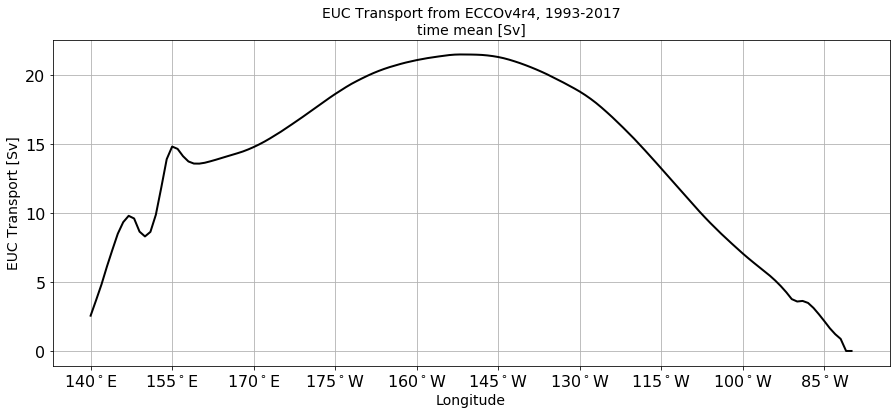

In [41]:
fig,ax = plt.subplots(1,1,figsize=(15,6))

ax.plot(lon_index,euc.trsp,'k')
plt.grid();
dx = 15
ax.set_xticks(lon_index[slice(0,None,dx)])
ax.set_xticklabels(lon_label[slice(0,None,dx)]);
ax.set_ylabel('EUC Transport [Sv]')
ax.set_title('EUC Transport from ECCOv4r4, 1993-2017\ntime mean [Sv]')
ax.set_xlabel('Longitude');
fig.savefig(f'{fig_dir}/euc_eccov4r4.png',bbox_inches='tight',dpi=300)

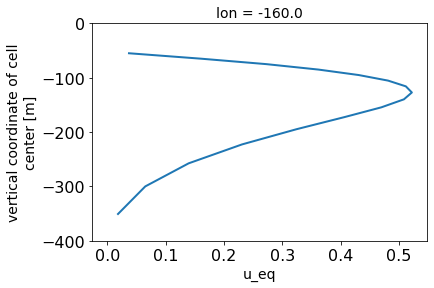

In [67]:
lon_sel
euc.sel(lon=-160).u_eq.where(euc.u_eq.sel(lon=-160)>0).plot(y='Z',ylim=[-400,0])

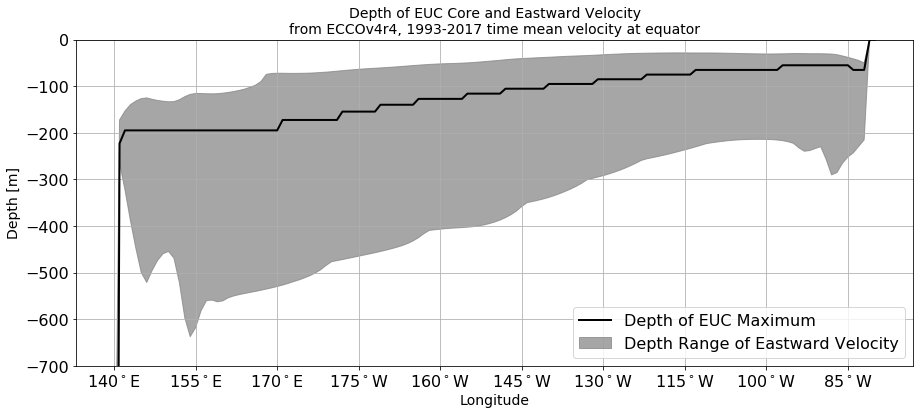

In [245]:
fig,ax = plt.subplots(1,1,figsize=(15,6))

#ax.plot(lon_index,euc.Zl_upper,'--')
ax.plot(lon_index,euc.Z_core,'k')
#ax.plot(lon_index,euc.Zl_lower,'k--')
ax.fill_between(lon_index,euc.Zl_lower,euc.Zl_upper,color='gray',alpha=0.7)
plt.ylim([-700,0])
plt.legend(('Depth of EUC Maximum','Depth Range of Eastward Velocity'),loc='lower right')
plt.grid();
dx = 15
ax.set_xticks(lon_index[slice(0,None,dx)])
ax.set_xticklabels(lon_label[slice(0,None,dx)]);
ax.set_ylabel('Depth [m]')
ax.set_title('Depth of EUC Core and Eastward Velocity\nfrom ECCOv4r4, 1993-2017 time mean velocity at equator');
ax.set_xlabel('Longitude');
fig.savefig('/workspace/results/eccov4r4/equatorial-under-current/figures/euc_core_depth.png',bbox_inches='tight',dpi=300)

## Plot some good stuff

In [29]:
lon_good = -140
lat1 = 1.5
lat2 = -1.5
tds140w = calc_euc(ds=ds,pt1=[lon_good,lat1],pt2=[lon_good,lat2],grid=grid)

/workspace/ECCOv4-py/ecco_v4_py/get_section_masks.py:51: UserWarning: 
Section name euc unavailable as pre-defined section
  warnings.warn('\nSection name %s unavailable as pre-defined section' % section_name)


In [30]:
tds140w

<xarray.Dataset>
Dimensions:   (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, tile: 13, time: 312)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T12:00:00 ... 2017-12-16
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    PHrefC    (k) >f4 49.05 147.15 245.25 ... 49435.043 53574.863 57940.312
    drF       (k) >f8 10.0 10.0 10.0 10.0 10.0 ... 364.5 387.5 410.5 433.5 456.5
    Z         (k) float32 -5.0 -15.0 -25.0 -35.0 ... -5039.25 -5461.25 -5906.25
    k_p1      int64 21
    drC       float64 59.25
    PHrefF    >f4 3709.9458
    Zp1       >f8 -378.2
  * tile      (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i         (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
Data variables:
    trsp_z    (time, k) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    trsp      float64 20.75
    maskW     (tile, j, i_g) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    maskS     (tile, j_g, i) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Z_core    float32 -95.095
    u_eq      (k) float32 -0.33538437 -0.3060344 -0.1922858 ... 0.0 0.0 0.0
    Zl_lower  float32 -338.51852
    Zl_upper  float32 -37.756447

In [31]:
trsp_per_width = (ds.VVELMASS*tds140w['maskS']).isel(tile=8).sum('j_g')

In [32]:
trsp_per_width['d'] = -ds.Z.copy()

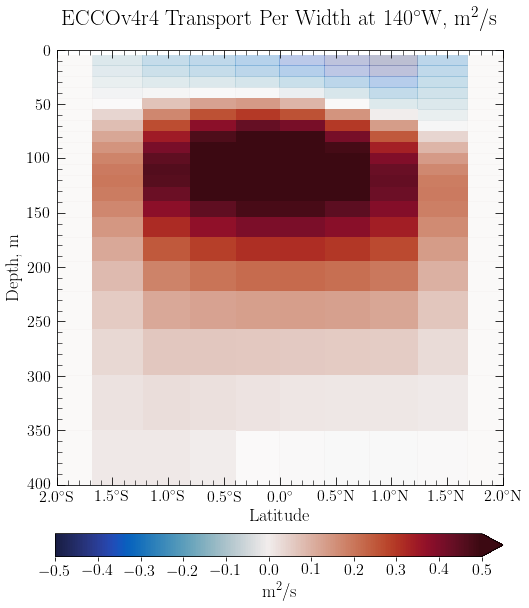

In [34]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
yc = ds.YG.isel(tile=8).isel(j_g=0)
p1=ax.pcolormesh(yc,trsp_per_width['d'],
                 trsp_per_width,cmap='cmo.balance',alpha=.3,rasterized=True,
                 vmin=-.5,vmax=.5)
p2=ax.pcolormesh(yc,trsp_per_width['d'],
                 trsp_per_width.where(trsp_per_width>0),cmap='cmo.amp',alpha=1,rasterized=True,
                 vmin=0,vmax=0.5)
xticks = [-2,-1.5,-1,-.5,0,.5,1,1.5,2]
xticklabels = [2,1.5,1,.5,0,.5,1,1.5,2]
ax.set(ylabel='Depth, m',xlabel='Latitude',
       ylim=[400,0],xlim=[-2,2],xticks=xticks,
       xticklabels=[r'%.1f$^\circ$%s' % (x,y) for x,y in zip(xticklabels,['S']*4+['']+['N']*4)]);

ax.set_title(r'ECCOv4r4 Transport Per Width at 140$^\circ$W, m$^2$/s',pad=25)

# colorbar
cax = fig.add_axes([0.123,0, 0.777, 0.04])
cbar=fig.colorbar(p1,cax=cax,ax=ax,label=r'm$^2$/s',orientation='horizontal',extend='max')
cbar.set_ticks(-.5+0.1*np.arange(11))
cbar.set_alpha(1)
cbar.draw_all()
nice_inward_ticks(ax=ax,xminor_skip=0.1,yminor_skip=10)
fig.savefig(f'{fig_dir}/eccov4r4_trspperwidth_140w.png',bbox_inches='tight',dpi=300,pad_inches=1)

In [82]:
trsp_per_width.min()

<xarray.DataArray ()>
array(-0.44651923)
Coordinates:
    tile     int64 8
    k_p1     int64 21
    drC      float64 59.25
    PHrefF   >f4 3709.9458
    Zp1      >f8 -378.2

In [47]:
tds145w.u_eq

<xarray.DataArray 'u_eq' (k: 50, tile: 13, i_g: 90)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    PHrefC   (k) >f4 49.05 147.15 245.25 ... 49435.043 53574.863 57940.312
    drF      (k) >f8 10.0 10.0 10.0 10.0 10.0 ... 364.5 387.5 410.5 433.5 456.5
    Z        (k) float32 -5.0 -15.0 -25.0 -35.0 ... -5039.25 -5461.25 -5906.25
    k_p1     int64 21
    drC      float64 59.25
    PHrefF   >f4 3709.9458
    Zp1      >f8 -378.2

In [239]:
lon_bad = 158
lat1 = 1.5
lat2 = -1.5
tds158e = calc_euc(ds=ds,pt1=[lon_bad,lat1],pt2=[lon_bad,lat2],grid=grid)

/workspace/ECCOv4-py/ecco_v4_py/get_section_masks.py:51: UserWarning: 
Section name euc unavailable as pre-defined section
  warnings.warn('\nSection name %s unavailable as pre-defined section' % section_name)


Text(0.5, 0, 'Zonal Velocity at Equator [m/s]')

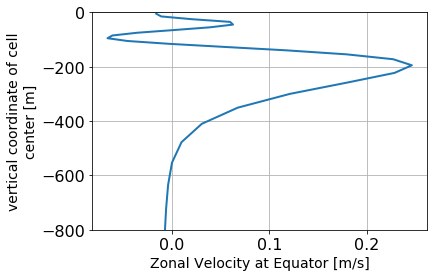

In [240]:
tds158e.v_eq.plot(y='Z',ylim=[-800,0])
plt.grid();
plt.xlabel('Zonal Velocity at Equator [m/s]')
#plt.savefig('/workspace/results/eccov4r4/equatorial-under-current/figures/zonal_velocity_many_zeros.png',bbox_inches='tight',dpi=300)

In [241]:
tds158e.Zl_upper

<xarray.DataArray 'Zl_upper' ()>
array(-116.298256, dtype=float32)

In [242]:
tds158e.Zl_lower

<xarray.DataArray 'Zl_lower' ()>
array(-558.93964, dtype=float32)

## Make dataset nice and save to a couple different formats

In [247]:
euc['lon_index'] = lon_index
euc['lon_label'] = lon_label

In [248]:
euc['trsp'].attrs['long_name'] = 'Equatorial Under Current (EUC)'
euc['trsp'].attrs['Definition'] = 'Time mean (positive only, eastward) zonal velocity integrated 0-400m depth, 1.5S to 1.5N'
euc.attrs['Description'] = 'EUC from ECCOv4r4, computed by Tim Smith'

In [249]:
euc['Z_core'].attrs['long_name'] = 'Depth of maximum (eastward) zonal velocity'
euc['Z_core'].attrs['units'] = 'm'

euc['Zl_lower'].attrs['long_name'] = 'Lower bound of EUC'
euc['Zl_lower'].attrs['Description'] = 'Depth where zonal velocity transitions from positive to negative, above the "core" depth, linearly interpolated based on time mean zonal velocity value.'
euc['Zl_lower'].attrs['units'] = 'm'

euc['Zl_upper'].attrs['long_name'] = 'Upper bound of EUC'
euc['Zl_upper'].attrs['Description'] = 'Depth where zonal velocity transitions from negative to positive, above the "core" depth, linearly interpolated based on time mean zonal velocity value.'
euc['Zl_upper'].attrs['units'] = 'm'

In [250]:
euc.to_netcdf('/workspace/results/eccov4r4/equatorial-under-current/euc_eccov4r4.nc')

In [251]:
df = euc['trsp'].to_dataframe()

In [253]:
df.to_csv('/workspace/results/eccov4r4/equatorial-under-current/euc_eccov4r4.csv')